# Utility under information leakage

Results are produced by executing script **real.sh** and they are presented in Figure 2.

In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns
import glob
import json
from lib import utils
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
sns.set_context("paper", font_scale=4)

In [3]:
name="real"
datas="fico"
final_df = []
cols = sns.color_palette("husl",5)
cols_new = sns.color_palette("Set2")

In [4]:
files = glob.glob("./outputs/{name}_greedydet_data_{datas}*_config.json".format(name=name, datas=datas))
data = []

for fi in files:
    with open(fi,"r") as file:
        data.append(json.load(file))

non_strategic_utility = data[0]['non_strategic']

In [5]:
files = glob.glob("./outputs/{name}_greedyrand_data_{datas}*_config.json".format(name=name, datas=datas))
data = []

for fi in files:
    with open(fi,"r") as file:
        temp_data=json.load(file)
        leak_results = temp_data['leaking_results']
        for pr,u in leak_results.items():
            new_data={}
            new_data['k'] = temp_data['k']
            new_data['leaking'] = float(pr)
            new_data['greedy_rand'] = u
            data.append(new_data)

df_standard = pd.DataFrame(data)
final_df.append(df_standard.melt(id_vars=["k", "leaking"], var_name="algorithm", value_name="utility"))

In [6]:
df = pd.concat(final_df)

In [7]:
df['algorithm'] = df['algorithm'].str.replace("greedy_rand", "Algorithm 2")

In [8]:
df['algorithm'].unique()

array(['Algorithm 2'], dtype=object)

In [9]:
df = df[df['k']!=2]

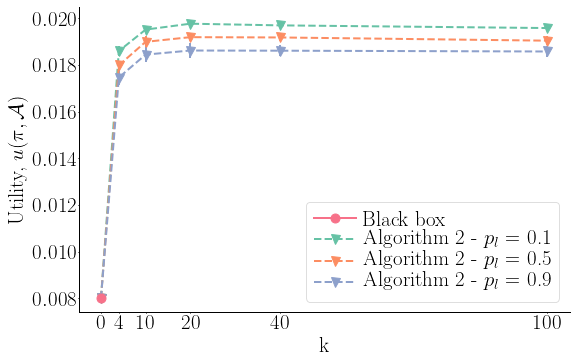

In [10]:
utils.latexify(8.8,5.5, font_scale=3.0)
lines={}
ls=df['leaking'].unique()
ks=df['k'].unique()
for l_val in sorted(ls):
    lines[l_val]=[]
    for k_val in ks:
        line_l=pd.DataFrame(df[(df['leaking']==l_val) & (df['k']==k_val)], columns=['utility']).values.tolist()
        lines[l_val].append((k_val,np.mean(line_l),np.std(line_l)))

ax = plt.subplot(111)
ax.plot([0], non_strategic_utility, linestyle='-', marker='o', label='Black box', markersize=9, color=cols[0], linewidth=2, zorder=20)
legends=['Black box']

colors=[cols_new[0],cols_new[1],cols_new[2]]
for i,l in enumerate(sorted(ls)):
    line_sorted=sorted(lines[l], key=lambda x:x[0])
    x_vals=[0]+[x[0] for x in line_sorted]
    y_vals=[non_strategic_utility]+[x[1] for x in line_sorted]
    y_err=[0]+[x[2] for x in line_sorted]
    ax.errorbar(x_vals, y_vals, yerr=y_err, linestyle='--', label='Algorithm 2'+str(l), marker='v', markersize=9, color=colors[i], linewidth=2)
    legends.append('Algorithm 2 - $p_l$ = '+str(l))

handles,_ = ax.get_legend_handles_labels()
handles[1:] = [h[0] for h in handles[1:]]
plt.legend(handles, legends, shadow=None, loc=4,labelspacing=0.1, handletextpad=0.3)
plt.ylabel("Utility, $u(\\pi,\\mathcal{A})$")
plt.xlabel("k")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(x_vals)
plt.savefig("./figures/leak_{datas}_comp.pdf".format(datas=datas),bbox_inches='tight', )